---

Universidade Federal do Rio Grande do Norte

Centro de Tecnologia

Departamento de Engenharia de Computação e Automação

ELE0606 - Tópicos especiais em inteligência artificial

Student: Levy Gabriel da Silva Galvão

Título: Natural Language Processing with K-means

---

# Libraries import

In [21]:
# Data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme();

import time
import requests
import re
import multiprocessing

!pip install kneed &> /dev/null
!pip install vagalume &> /dev/null

from bs4 import BeautifulSoup
from vagalume import lyrics
from google.colab import files
from tqdm import tqdm
from kneed import KneeLocator

# Preprocess
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature extraction
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


# Machine Learning

from sklearn import utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Objective

The objective of this work is to parse the lexical composing of the lyrics of The Smiths in all its discography with K-Means clustering in the Natural Language Processing context.

# Data fetching

The first thing to do is to get the hands in all lyrics from the band. This will be made using the [vagalume](https://github.com/diegoteixeir4/python-vagalume) API for Python. But the API requires at least the name of the song to fetch the lyrics. So the first priority is to list all the knowing songs of The Smiths.

There is a [wikipedia page](https://en.wikipedia.org/wiki/List_of_songs_recorded_by_the_Smiths) that lists all songs recorded by The Smiths and with it all sorts of information. But first, it will be used the `requests` library from Python to get the `.html` content of this page and then use `BeautifulSoup` to parse the text to extract the table with all data. The code below build the data set that lists all The Smiths musics.

In [2]:
# https://stackoverflow.com/questions/64513615/how-can-i-extract-a-table-from-wikipedia-using-beautiful-soup
page = requests.get('https://en.wikipedia.org/wiki/List_of_songs_recorded_by_the_Smiths').text
soup = BeautifulSoup(page, 'html.parser')
table = soup.find('table', class_="wikitable sortable plainrowheaders")

df = pd.read_html(str(table))
df = pd.concat(df)

df['Song'] = [re.search(r".+?(?=\")", song).group(0).replace('"','') for song in df['Song']]
df = df.drop_duplicates(['Song'])
df.sample(5)

,Song,Writer(s),Original release,Year,Ref(s)
52,Still Ill,Johnny MarrMorrissey,The Smiths,1984,[29]
51,Some Girls Are Bigger Than Others,Johnny MarrMorrissey,The Queen Is Dead,1986,[22]
19,The Headmaster Ritual,Johnny MarrMorrissey,Meat Is Murder,1985,[21]
73,You've Got Everything Now,Johnny MarrMorrissey,The Smiths,1984,[29]
4,Barbarism Begins at Home,Johnny MarrMorrissey,Meat Is Murder,1985,[21]


The table contains six columns with data regarding:

In [3]:
print(list(df.columns))

['Song', 'Writer(s)', 'Original release', 'Year', 'Ref(s)']


In this analysis the `Writer(s)` and `Ref(s)` will be discarded and the remaining columns will be renamed to `song`, `release` and `year`.

In [4]:
df = df.drop(columns=['Writer(s)', 'Ref(s)'])
df.columns = ['song','release','year']
df['song'] = df['song'].str.lower()
df['release'] = df['release'].str.lower()
df.sample(5)

,song,release,year
29,is it really so strange?,"louder than bombs(b-side to ""sheila take a bow"")",1987
65,well i wonder,meat is murder,1985
4,barbarism begins at home,meat is murder,1985
17,the hand that rocks the cradle,the smiths,1984
44,reel around the fountain,the smiths,1984


Next the lyrics are fetched and concatenated to the dataset:

In [7]:
list_ = []
for s in df['song']:
  while True:
    try:
      result = lyrics.find('the smiths', s)
      break
    except: pass
  if not result.is_not_found(): list_.append(result.song.lyric)
df['lyrics'] = pd.Series(list_)
df.head(3)

,song,release,year,lyrics
0,accept yourself,hatful of hollow,1984,"Every day you must say\nSo, how do I feel abou..."
1,ask,the world won't listen(non-album single),1986,"Shyness is nice, and\nShyness can stop you\nFr..."
2,asleep,"the world won't listen(b-side to ""the boy with...",1985,Sing me to sleep\nSing me to sleep\nI'm tired ...


After fetching the lyrics some information are checked to see if there is any NULL variable.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   song     74 non-null     object
 1   release  74 non-null     object
 2   year     74 non-null     int64 
 3   lyrics   73 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.9+ KB


Since there is a lyric missing for a song, this row must be excluded

In [15]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   song     73 non-null     object
 1   release  73 non-null     object
 2   year     73 non-null     int64 
 3   lyrics   73 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.9+ KB


Thus the dataset is saved for later use.

In [17]:
df.to_csv('the_smiths_songs.csv')
files.download('the_smiths_songs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preprocessing

For preprocessing, first the data set is properly load from GitHub:

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/Lwao/awesome-ai/main/ufrn-ai/datasets/the_smiths_songs.csv', 
            usecols=['song','release','year','lyrics'])
df.head()

,song,release,year,lyrics
0,accept yourself,hatful of hollow,1984,"Every day you must say\nSo, how do I feel abou..."
1,ask,the world won't listen(non-album single),1986,"Shyness is nice, and\nShyness can stop you\nFr..."
2,asleep,"the world won't listen(b-side to ""the boy with...",1985,Sing me to sleep\nSing me to sleep\nI'm tired ...
3,back to the old house,"hatful of hollow(b-side to ""what difference do...",1984,I would rather not go\nBack to the old house\n...
4,barbarism begins at home,meat is murder,1985,Unruly boys\nWho will not grow up\nMust be tak...


Then the data will be organized in such manner to guarantee more representative feature. Thus the preprocessing pipeline will contain:

1. Ensure all words in the lyrics are in lower case to avoid multiple representation and remove useless characters like: `\n`, `(`, `)`, `"`, `...`, `,`, `.`, `;`, `:`, `-`, `_`, `?`, `!`; that are not NLP interpretable;
2. Tokenization to separate all word in a lyric;
3. Remove stop words that are mainly used to connect meaningful word and they itself do not hold any significance for analysis;
4. Apply lemmatization to reduce the words for its radical, dissipating any verbs conjugation or plural of nouns;

In [27]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [38]:
def preprocess(text):
  stopwords = set(nltk.corpus.stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  words = re.findall(r'\b[A-zÀ-úü]+\b', text.lower()) # step 1 and 2
  meaningful_words= [i for i in words if not i in stopwords] # step 3
  rooted_meaningful_words = [lemmatizer.lemmatize(word) for word in meaningful_words] # step 4
  return rooted_meaningful_words

Below is a quick example of how the `preprocess` pipeline will work.

In [40]:
preprocess(r"Roses are red, violets don't")

['rose', 'red', 'violet']

Then proceed to get all meaningful words from The Smiths by applying the preprocessing pipeline:

In [60]:
def batch_preprocess(series_):
  return (" ".join([" ".join(preprocess(lyric)) for lyric in series_])).split()

tokens = batch_preprocess(df['lyrics'])
tokens[:5]

['every', 'day', 'must', 'say', 'feel']

# Lexical frequency

In this section the word frequency will be analysed based on the words get from The Smiths discography. The frequency of the words can be obtained using NLTK. Then it can be plotted a given number of the most frequent words from The Smiths vocabulary, as seen below:

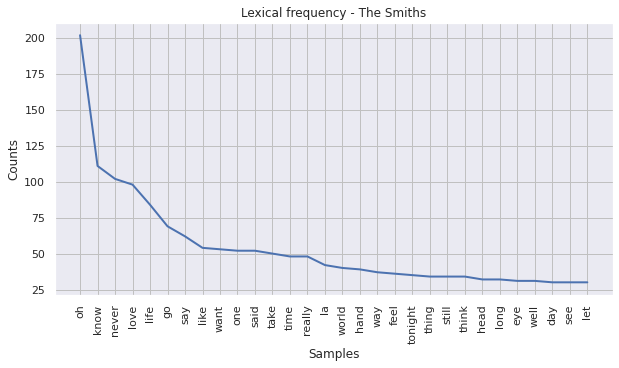

In [64]:
def frequency_plot(tokens, title):
  plt.figure(figsize=(10,5))
  fd = nltk.FreqDist(tokens)
  fd.plot(30,title=title,cumulative=False)

frequency_plot(tokens, "Lexical frequency - The Smiths")

Looking the plotting, they sure like to "Oh" around.

Since other columns exist in the data set, some narrow filters can be made to extract the lexical frequency of a restricted album or from a given year, in this case the examples are shown below.

Some albums: ['hatful of hollow' "the world won't listen(non-album single)"
 'the world won\'t listen(b-side to "the boy with the thorn in his side")']


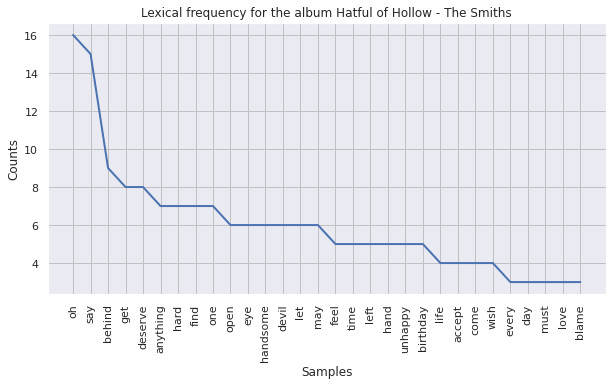

In [65]:
print('Some albums: ' + str(df['release'].unique()[:3]))
frequency_plot(batch_preprocess(df['lyrics'][df['release']=='hatful of hollow']), 
               "Lexical frequency for the album Hatful of Hollow - The Smiths")

Year of releases: [1984 1986 1985 1987 1988 1983]


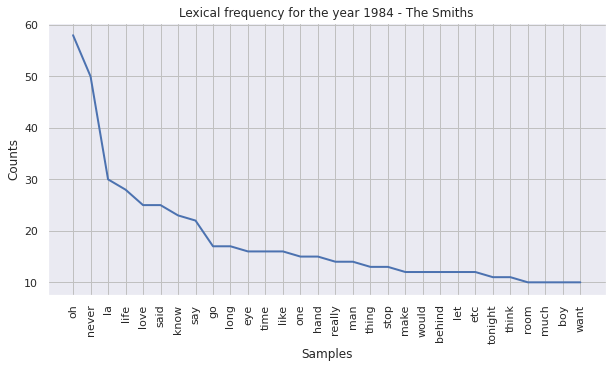

In [68]:
print('Year of releases: ' + str(df['year'].unique()))
frequency_plot(batch_preprocess(df['lyrics'][df['year']==1984]), 
               "Lexical frequency for the year 1984 - The Smiths")

# Group by similarities

In this last section the content of the musics will be vectorized using `Doc2Vec`, so each music can be represented by a $\text{n} \; th$ dimensional vector, thus allowing to algebrically compare each vector.



As a disclaimer, the `Doc2Vec` will use the Distributed Bag of Words (DBOW) architecture.

In this case the data should be organized as a `TaggedDocument` so each music lyrics are associated correctly.

In [80]:
df['td'] = df.apply(lambda r: TaggedDocument(words=preprocess(r['lyrics']), tags=[r.song]), axis=1).values
df.filter(['lyrics','td']).head()

,lyrics,td
0,"Every day you must say\nSo, how do I feel abou...","([every, day, must, say, feel, life, anything,..."
1,"Shyness is nice, and\nShyness can stop you\nFr...","([shyness, nice, shyness, stop, thing, life, l..."
2,Sing me to sleep\nSing me to sleep\nI'm tired ...,"([sing, sleep, sing, sleep, tired, want, go, b..."
3,I would rather not go\nBack to the old house\n...,"([would, rather, go, back, old, house, would, ..."
4,Unruly boys\nWho will not grow up\nMust be tak...,"([unruly, boy, grow, must, taken, hand, unruly..."


The format of each lyric is:

In [82]:
df.sample(1)['td'].iloc[0]

TaggedDocument(words=['oh', 'hello', 'ghost', 'troubled', 'joe', 'hung', 'pretty', 'white', 'neck', 'eighteen', 'month', 'ago', 'travelled', 'mystical', 'time', 'zone', 'missed', 'bed', 'soon', 'came', 'home', 'said', 'much', 'caffeine', 'bloodstream', 'lack', 'real', 'spice', 'life', 'said', 'leave', 'alone', 'alright', 'dad', 'surprised', 'still', 'oh', 'mention', 'love', 'hate', 'strain', 'pain', 'rush', 'push', 'land', 'stand', 'shall', 'people', 'uglier', 'take', 'need', 'leave', 'oh', 'mention', 'love', 'hate', 'pain', 'strain', 'rush', 'push', 'land', 'stand', 'people', 'weaker', 'take', 'want', 'life', 'oh', 'mention', 'love', 'mention', 'love', 'rush', 'push', 'land', 'stand', 'youth', 'may', 'gone', 'still', 'young', 'man', 'phone', 'phone', 'phone', 'phone', 'phone', 'phone', 'oh', 'think', 'love', 'oh', 'think', 'love', 'oh', 'think', 'love', 'think', 'love', 'oh', 'think', 'love', 'oh'], tags=['rubber ring'])

After that the `Doc2Vec` can be instantiated and have its model build on top of the musics vocabulary.

In [92]:
# https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

cores = multiprocessing.cpu_count()

# build vocabulary
model = Doc2Vec(dm=0, # PV-DBOW
                vector_size=1000, # feature vector size
                negative=5, # drawn noise words
                hs=0, # negative sampling wil be used
                min_count=2, # ignore words with lesser frequency
                sample=0, # threshold for random smapling
                workers=cores # number of cores
                )
model.build_vocab([x for x in tqdm(df['td'])])
print(model)

100%|██████████| 73/73 [00:00<00:00, 104321.70it/s]


Doc2Vec(dbow,d1000,n5,mc2,t2)


Then training:

In [97]:
%%time
n = len(df['td'])
for epoch in range(10):
  model.train(utils.shuffle([x for x in tqdm(df['td'])]), total_examples=n, epochs=1)
  model.alpha -= 0.002
  model.min_alpha = model.alpha

100%|██████████| 73/73 [00:00<00:00, 304358.04it/s]


CPU times: user 256 ms, sys: 15.5 ms, total: 272 ms
Wall time: 331 ms


The feature vectors for each lyric are built, now it remains to associate each one of the songs to the respective vector in a algebric manner to ease of use when training the K-means model.

In [106]:
def get_music_vectors(model, lyrics):
    musics, vec_lyrics = zip(*[(lyric.tags[0], model.infer_vector(lyric.words, steps=20)) for lyric in lyrics])
    return musics, np.array(vec_lyrics)

musics, vec_lyrics = get_doc_vectors(model, df['td'])

Before training the vectorized values of the lyrics are scaled with a min-max scaler as best practices for the ML model traning.

In [108]:
X = MinMaxScaler().fit_transform(vec_lyrics)
y = musics

Then a PCA plot function is defiend below so the dataset can be visualized in a lower dimension than the $1000 \; th$ dimensional feature vector. The dimension of reduction is set to 2D.

In [141]:
def pca_plot(X, y, title):
  pca = PCA(n_components=2)
  X2D = MinMaxScaler().fit_transform(pca.fit(X).transform(X)) # feature matrix after pca

  print('Explained variance ratio: %s' % str(pca.explained_variance_ratio_))

  plt.figure()
  for i in range(len(y)):
    plt.scatter(
      x=X2D[i,0], y=X2D[i,1], c=[np.random.rand(3)], 
    )
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)
  #ax = plt.gca()
  #ax.legend_ = None
  plt.show()

Explained variance ratio: [9.98698577e-01 4.33261527e-04]


No handles with labels found to put in legend.


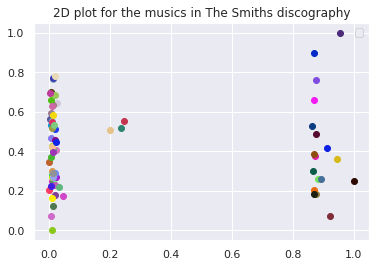

In [142]:
pca_plot(X, y, '2D plot for the musics in The Smiths discography')

The plot has two main clusters. Remains to know if K-means will detect these clusters.

The PCA is a good metric of reduction to 2D since both components holds more than 99.9% of explained variance from the original dataset.

Before applying K-means the elbow method is used do define the ideal number of clusters based in the inertia parameter. Then the test is realized up to 15 clusters and the inertia array is plotted below.

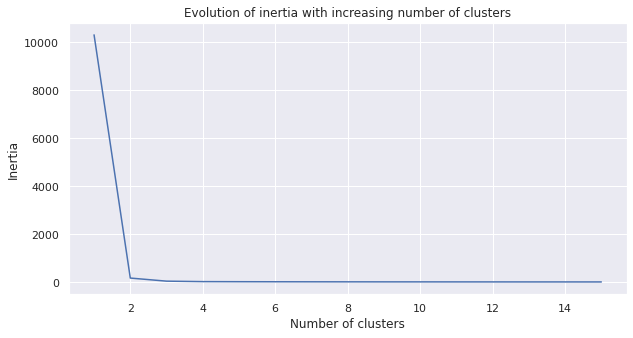

In [143]:
range_ = np.arange(1,15+1,1)
inertia = []

for k in range_:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  inertia.append(kmeans.inertia_)

cluster_df = pd.DataFrame({'cluster':range_, 'inertia':inertia})
cluster_df.head()

plt.figure(figsize=(10,5))
plt.plot(cluster_df['cluster'], cluster_df['inertia'])
plt.title('Evolution of inertia with increasing number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

As seen in the PCA plot, the elbow method returned 2 clusters as ideal for the K-means training. To better confiramtion the libary `kneed` was used to detect the knee of which represents the number of clusters that the inertia stagnates and, again confirming 2 as the ideal number.

In [144]:
kl = KneeLocator(cluster_df['cluster'], cluster_df['inertia'], curve="convex", direction="decreasing" )
kl.elbow

2

To visualze the results, PCA is again used to reduce the data and the cluster centroids to 2D.

In [159]:
def kmeans_pca_plot(X, kmeans, title, y=pd.Series(dtype=np.object)):
  pca = PCA(n_components=2)
  X2D = pca.fit(X).transform(X)
  CENT = pca.transform(kmeans.cluster_centers_)
  plt.figure(figsize=(7,7))

  if(y.empty):
    c = np.random.rand(len(kmeans.labels_),3)
    for i in range(len(kmeans.labels_)): 
      plt.scatter(X2D[i,0], X2D[i,1], s=50, c=[c[kmeans.labels_[i]]],) #marker='$'+str(kmeans.labels_[i])+'$')
  else:
    y = np.array(y)
    u = np.unique(y)
    n = len(u)
    for i in range(n): 
      plt.scatter(X2D[y==u[i],0], X2D[y==u[i],1], s=50, c=np.random.rand(1,3), label=str(u[i])) #marker='$'+str(kmeans.labels_[i])+'$')
  
  plt.scatter(CENT[:, 0], CENT[:, 1], s=300, c='blue', label='Centroids')
  plt.title(title)
  plt.legend();

Finally the K-means model can be trained:

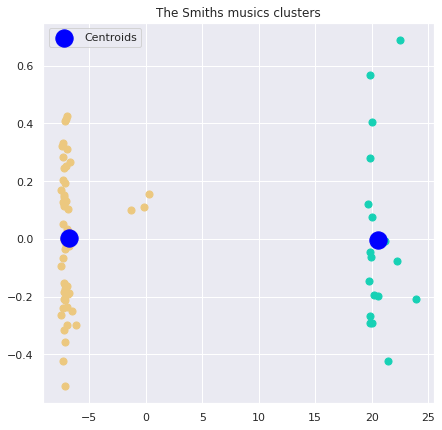

In [164]:
kmeans = KMeans(kl.elbow)
kmeans = kmeans.fit(X)
kmeans_pca_plot(X,kmeans,title='The Smiths musics clusters')

Despite using the optimal number of clusters, there is still 3 musics that are a little far from the centroid. Thus when applying K-means again for 3 clusters, these musics are easily assigned to the new cluster.

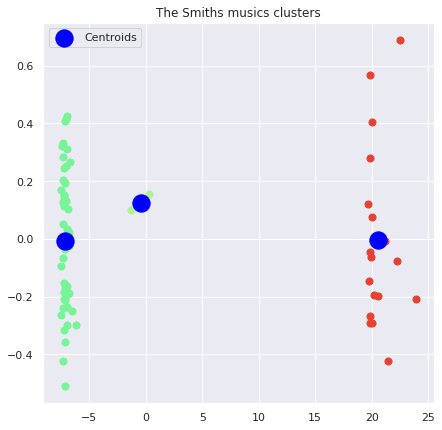

In [165]:
kmeans = KMeans(3)
kmeans = kmeans.fit(X)
kmeans_pca_plot(X,kmeans,title='The Smiths musics clusters')

Now knowing that The Smiths had two or three main tendencies in its musics, lets check if these dissimilarities has anything to do with the album that each music is on:

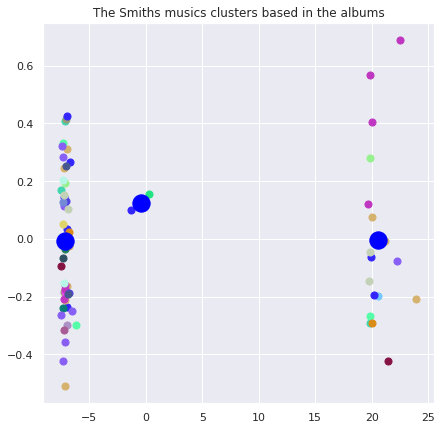

In [178]:
kmeans_pca_plot(X, kmeans, 'The Smiths musics clusters based in the albums', y=df['release'])
ax = plt.gca()
ax.legend_ = None

Or the year of release:

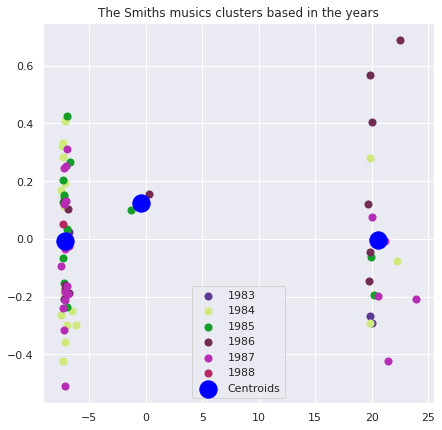

In [176]:
kmeans_pca_plot(X, kmeans, 'The Smiths musics clusters based in the years', y=df['year'])

Neither the year or album has clear influency in the lyrics of the musics.

Concluding this analysis, this work allowed to develop a methodology for classifying different documents, since a music lyric has same structure as any other textual genre.

For more complex works this might be a viable analysis to defined pattern of similarities between documents, enabling a quick organization of documents.